In [121]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [94]:
train_dir = r"C:\Users\M S I\Documents\BANGKIT\train"
test_dir = r"C:\Users\M S I\Documents\BANGKIT\test"

In [95]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for name in dirs:
            class_dir = os.path.join(root, name)
            num_files = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[name] = num_files
    return class_counts

In [96]:
# Hitung jumlah gambar per kelas di set pelatihan dan uji
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

In [97]:
# Buat DataFrame untuk visualisasi
df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
df_test = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

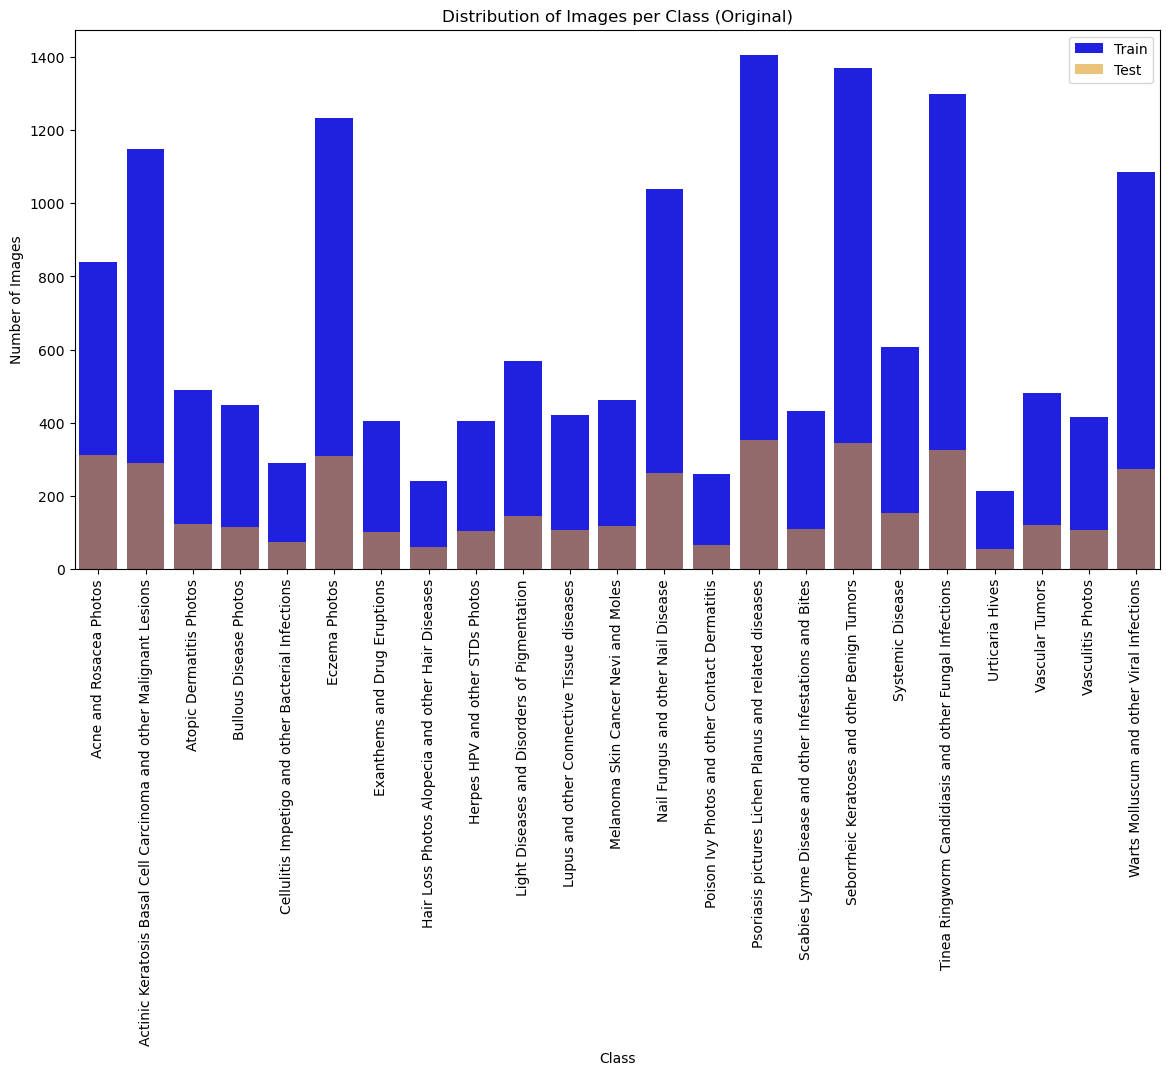

In [98]:
# Visualisasi distribusi gambar awal
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Count', data=df_train, color='blue', label='Train')
sns.barplot(x='Class', y='Count', data=df_test, color='orange', label='Test', alpha=0.6)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class (Original)')
plt.legend()
plt.show()

In [99]:
# Filter kelas yang memiliki lebih dari 1000 gambar
filtered_classes = [cls for cls, count in train_counts.items() if count > 1000]


In [100]:
# Path ke direktori baru untuk data yang telah difilter
filtered_train_dir = r"C:\Users\M S I\Documents\BANGKIT\train_filtered"
filtered_test_dir = r"C:\Users\M S I\Documents\BANGKIT\test_filtered"

In [101]:
# Buat direktori baru jika belum ada
if not os.path.exists(filtered_train_dir):
    os.makedirs(filtered_train_dir)

if not os.path.exists(filtered_test_dir):
    os.makedirs(filtered_test_dir)

In [102]:
# Salin gambar dari kelas yang dipilih ke direktori baru (train)
for cls in filtered_classes:
    src_class_dir = os.path.join(train_dir, cls)
    dst_class_dir = os.path.join(filtered_train_dir, cls)
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
    
    for file_name in os.listdir(src_class_dir):
        full_file_name = os.path.join(src_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst_class_dir)

# Salin gambar dari kelas yang dipilih ke direktori baru (test)
for cls in filtered_classes:
    src_class_dir = os.path.join(test_dir, cls)
    dst_class_dir = os.path.join(filtered_test_dir, cls)
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
    
    for file_name in os.listdir(src_class_dir):
        full_file_name = os.path.join(src_class_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dst_class_dir)

In [103]:
# Hasil akhir: kelas dengan >1000 gambar ada di filtered_train_dir dan filtered_test_dir
print(f"Kelas yang memiliki lebih dari 1000 gambar: {filtered_classes}")

Kelas yang memiliki lebih dari 1000 gambar: ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Eczema Photos', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


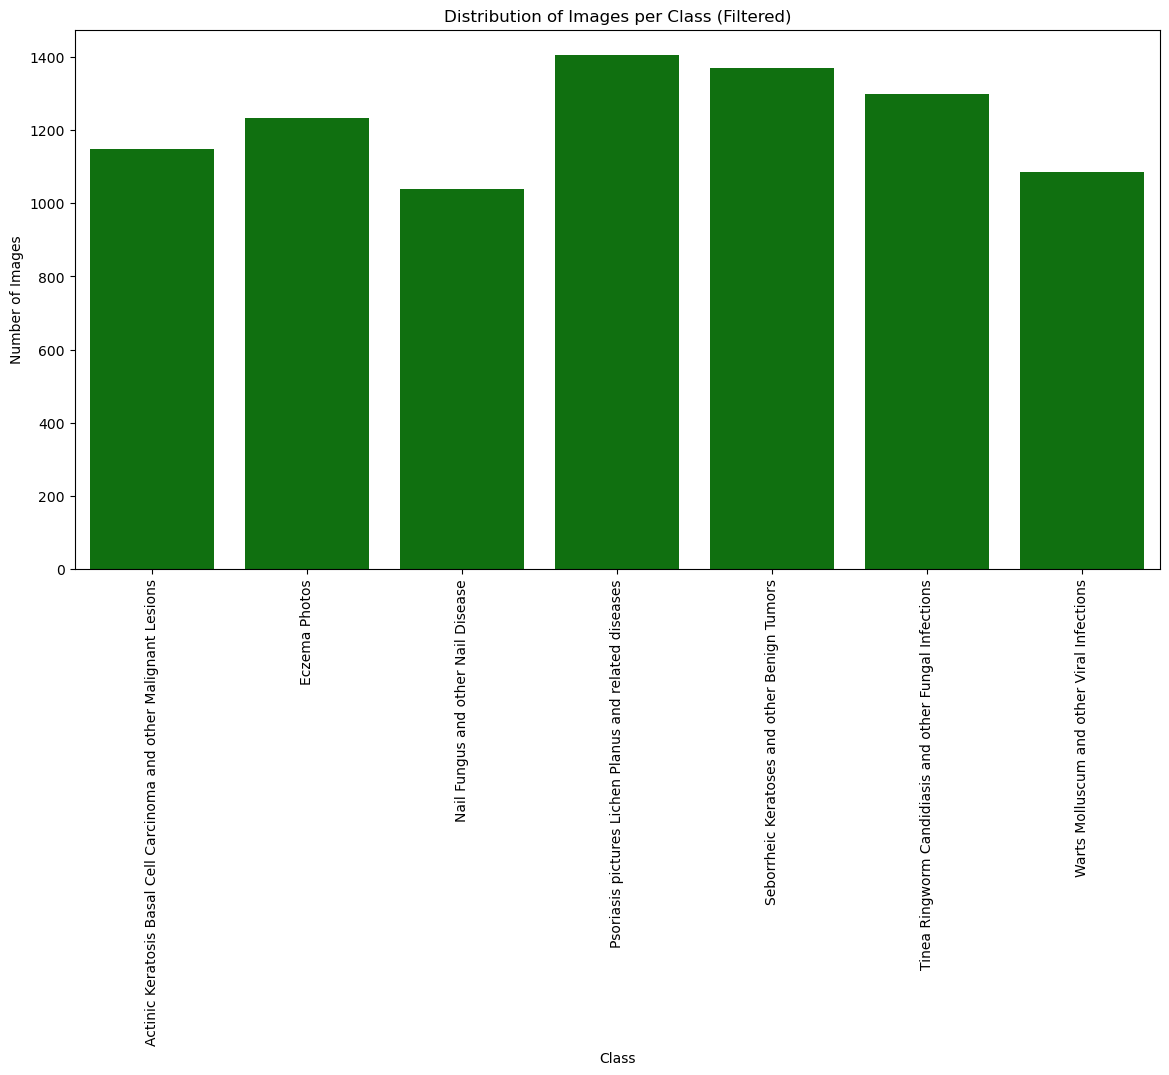

In [104]:
# Visualisasi distribusi gambar setelah filtering
filtered_train_counts = count_images_per_class(filtered_train_dir)
df_filtered_train = pd.DataFrame(list(filtered_train_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Count', data=df_filtered_train, color='green')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class (Filtered)')
plt.show()

In [124]:
# ImageDataGenerator untuk augmentasi dan normalisasi data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load dan preprocess filtered training data
train_generator = train_datagen.flow_from_directory(
    filtered_train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Gunakan 'categorical' untuk klasifikasi multi-kelas
)

# Load dan preprocess filtered testing data
test_generator = test_datagen.flow_from_directory(
    filtered_test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Gunakan 'categorical' untuk klasifikasi multi-kelas
)

Found 8586 images belonging to 7 classes.
Found 2150 images belonging to 7 classes.


In [106]:
# Ambil jumlah kelas dari train_generator
num_classes = len(train_generator.class_indices)

In [107]:
# Build the CNN model
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Steps per epoch untuk pelatihan
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, test_generator.samples // test_generator.batch_size)

# Ringkasan model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,816,967 (26.00 MB)

 Trainable params: 6,816,007 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [108]:
# Pelatihan model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Anda dapat mengubah jumlah epoch sesuai kebutuhan
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/30


C:\Users\M S I\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


268/268 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.1820 - loss: 5.1872 - val_accuracy: 0.1535 - val_loss: 2.0702
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step - accuracy: 0.2188 - loss: 1.8105 - val_accuracy: 0.0000e+00 - val_loss: 2.5909
Epoch 3/30


C:\Users\M S I\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


268/268 ━━━━━━━━━━━━━━━━━━━━ 246s 910ms/step - accuracy: 0.2199 - loss: 1.9010 - val_accuracy: 0.2444 - val_loss: 1.8208
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 167us/step - accuracy: 0.2188 - loss: 1.8189 - val_accuracy: 0.3333 - val_loss: 1.7534
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 241s 891ms/step - accuracy: 0.2302 - loss: 1.8805 - val_accuracy: 0.2024 - val_loss: 3.0715
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 175us/step - accuracy: 0.2812 - loss: 1.7853 - val_accuracy: 0.1667 - val_loss: 4.0042
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 238s 881ms/step - accuracy: 0.2433 - loss: 1.8523 - val_accuracy: 0.2383 - val_loss: 1.8254
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 164us/step - accuracy: 0.2500 - loss: 1.7106 - val_accuracy: 0.1667 - val_loss: 1.8200
Epoch 9/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 237s 874ms/step - accuracy: 0.2502 - loss: 1.8670 - val_accuracy: 0.2743 - val_loss: 1.7708
Epoch 10/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 167us/step - accuracy: 0.2500 - loss: 1.8020 - va

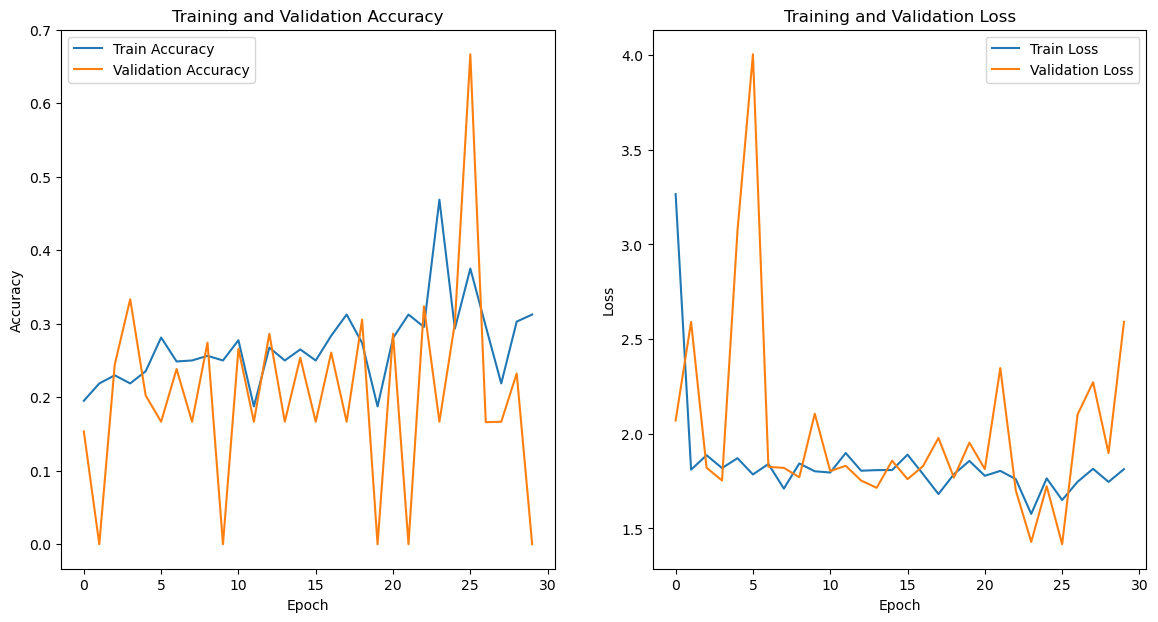

In [109]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [110]:
# Save the model
model.save('cnn_skin_disease_classifier.h5')



In [111]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {accuracy:.4f}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.2254 - loss: 1.9070
Test accuracy: 0.2332
